In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("/content/perez-fornos-2012_2xinterp.csv")
start_col_index = df.columns.get_loc("0.0")


# Use the column index to select the desired range of columns and convert to a NumPy array
data_np = df.iloc[:, start_col_index:].to_numpy()


#get rid of all the nan data
data_np = np.nan_to_num(data_np)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

max_range = len(data_np[44])
y_indices = {
    1: list(range(121)),  # This will create a list of integers from 0 to 61 inclusive
    2: list(range(121)),
    3: list(range(121)),
    4: list(range(41)),  # This will create a list of integers from 0 to 19 inclusive
    5: list(range(280)),  # Replace max_range with the actual upper limit for key 5
}

#x_map corresponds to the time domain values for each test
x_map = {
    1:np.linspace(0,30,121),
    2:np.linspace(0,30,121),
    3:np.linspace(0,30,121),
    4:np.linspace(0,10,41),
    5:np.linspace(0,70,280),
}

our first step is to find the optimal value to force the signal down to 0. i think the best way to do this is by searching the array to find an t_0 at which point all the y values to the right of it are < threshold.

In [ ]:
def find_t(y, threshold=1):
  for i in range(len(y)):
    found = False
    for j in range(i,len(y)):
      if y[j] > threshold:
        found = True
    if not found:
      return i
  return i

Processing the entire signal requires more terms. But we know that after t_0, our y values are basically 0. So instead of performing FFT analysis on the entire y, we process y[0:t_0]. This is better because it's really hard to model a signal that flatlines.

The code below takes the FFT of the signal and removes all coefficients less than the threshold. we will further process this fft and keep only n terms.

In [ ]:
def get_fft_res(y,t_0,spike=1):
  fft_res = np.fft.fft(y[spike:t_0+2])
  # Obtain the power spectrum (squared amplitude of each component)
  power_spectrum = np.abs(fft_res)**2
  # Zero out all small coefficients to remove noise
  threshold = 50
  fft_res[power_spectrum < threshold] = 0
  return fft_res

we pass the fft result to the function f which returns the filtered_fft and inverse fft that is an approximation of the signal built with only n terms

In [ ]:
from prompt_toolkit.formatted_text.utils import fragment_list_to_text

def f(fft_result,terms): #note: mag scale is not used, this param is set to 1 in training
  if terms == 0: return np.zeros(len(fft_result)), np.zeros(len(fft_result))
  fft_result = fft_result
  magnitudes = np.abs(fft_result)
  top_indices = np.argsort(magnitudes)[-1*terms:]

  filtered_fft = np.zeros_like(fft_result)
  filtered_fft[top_indices] = fft_result[top_indices]

  reconstructed_signal = np.fft.ifft(filtered_fft)

  # If you need just the real part (assuming the imaginary part is numerical noise)
  reconstructed_signal = reconstructed_signal.real

  return filtered_fft, reconstructed_signal

In [ ]:
import numpy as np

# Assuming fft_result is the output from the FFT.
# Number of sample points
def get_rec_signal(y,fft_res,terms=0,spike=1):
  filtered_fft, ifft = f(fft_res,terms)
  rec_signal = np.concatenate((ifft,np.zeros(len(y) - len(ifft) - spike)))
  return rec_signal

interpolate to improve the resolution

In [ ]:
def extend(x,y,rec_signal,spike=1):
  new_indices_fft = np.linspace(0, len(y), (len(y) - spike)*10) #i want to save 10 pts for the spike
  new_indices_y = np.linspace(0, len(y), (len(y))*10)

  x_extend = np.interp(new_indices_y, np.arange(len(y)), x)
  y_extend = np.interp(new_indices_y, np.arange(len(y)), y)
  y_pred_extend = np.interp(new_indices_fft,np.arange(len(y) - spike),rec_signal)
  return x_extend, y_extend, y_pred_extend

In [ ]:
from scipy.signal import find_peaks
def decay_only(y_pred_extend):
  # Find the first local maximum in the data
  first_peak_index, _ = find_peaks(y_pred_extend, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)
  if len(first_peak_index)==0:
    first_peak_index = np.append(first_peak_index,2)
  first_peak_y = y_pred_extend[first_peak_index[0]]

  # Make all values before the first local maxima NaN
  y_decayonly = np.copy(y_pred_extend)
  y_decayonly[:first_peak_index[0]] = np.nan
  return y_decayonly

In [ ]:
def add_spike(spike,y_decayonly,x_extend):
  #add the first spike which is just a linear interpolation
  y_spike = np.linspace(0, 10, spike*10)
  y_model = np.concatenate((y_spike,y_decayonly))

  #remove nan
  non_nan_indices = ~np.isnan(y_model)
  x_non_nan = x_extend[non_nan_indices]
  y_non_nan = y_model[non_nan_indices]

  # Interpolate using `numpy.interp` for the NaN values
  # We interpolate over the original x-values using the non-NaN subsets of the data
  y_interpolated = np.interp(x_extend, x_non_nan, y_non_nan)
  return y_interpolated

In [ ]:
#how to force the end to zero??
def force_to_zero(t_0,y_interpolated):
  y_interpolated[t_0*10:] = 0
  return y_interpolated

Finally, apply a smoothing filter on the data... This makes some graphs look nicer (refines the piecewise connections), and others look worse :(

In [ ]:
from scipy.ndimage import gaussian_filter

def apply_gaussian_filter(data, spike, sigma):
    smoothed_part = gaussian_filter(data[spike*10:], sigma=sigma)
    data[spike*10:] = smoothed_part
    data[0] = 0
    return data

RECAP of the procedure:

1) find the optimal t_0 value to cut the signal to 0

2) perform the fft analysis on the signal from y[1:t_0] (we ignore the spike and only model the decay)

3)concatenate the spike to the front of the model and flatline the model at t_0

4)apply a guassian filter

In [ ]:
from sklearn.metrics import r2_score, explained_variance_score

def calculate_r2(y_pred,y_actual,eps=1e-8,r2=True):
  if r2:
    value = r2_score(y_actual, y_pred)
  else:
    actual = (y_actual - y_actual.mean()) / (y_actual.std(ddof=0) + eps)
    pred = (y_pred - y_pred.mean()) / (y_pred.std(ddof=0) + eps)
    value = (actual * pred).mean()
  return value

def test(x,y,title="Reconstructed Signal",terms=2,show=False,spike=4, scale=1, bias=0, zero=None, pred_extended=None):
  if zero:
    t_0 = int(zero * len(y))
  else:
    t_0 = find_t(y)

  fft_res = get_fft_res(y,t_0,spike=spike)
  rec_signal = get_rec_signal(y,fft_res,terms=terms,spike=spike)
  x_extend, y_extend, extended_rec_signal = extend(x,y,rec_signal,spike=spike)
  y_decayonly = decay_only(extended_rec_signal) + bias
  y_spike_and_decay = add_spike(spike,y_decayonly,x_extend)
  y_done = force_to_zero(t_0,y_spike_and_decay)
  y_smooth = apply_gaussian_filter(y_done,spike=spike,sigma=6)
  return y_smooth * scale, y_extend, x_extend

def calculate_mse(y_smooth,y,weight=False):
  total = 0
  if len(y_smooth) == len(y):
    for i in range(len(y)):
      total += np.abs(y_smooth[i] - y[i])**2
    return total/len(y)

Trying out cross validation here. pass the panels you want to train on in the train panels, and test again the "hold_out_panel", which is just one index. We are not really "training" on the train_panels, just finding the model that explains the average of them and seeing how well it explains the held out panel.

In [ ]:
def group(mylist, ci=False):
  averages = [sum(mylist[i:i+9]) / 9 for i in range(0, len(mylist), 9)]
  stds = [1.96/3 * np.std(mylist[i:i+9]) for i in range(0, len(mylist), 9)]
  if not ci: return averages
  if ci: return averages, stds

def group_by_subject(mylist,subject, ci=False):
  total, count = 0,0
  sublist = []
  for i, val in enumerate(mylist):
      if i % 9 == subject:
        sublist.append(val)
        count += 1
        total += val
  if not ci: return total/count
  if ci: return [total/count, np.std(sublist) * 1.96/np.sqrt(count)]


This code simply generates the "optimal" curve for each of the panels

In [ ]:
bl_start = 0
bl_end = 9
training_mse,validation_mse, training_r2, validation_r2, training_corr, validation_corr, validation_mse_cost, baseline_model = [],[],[],[],[],[],[],[]

In [ ]:
import random

def makebaseline(indices, j):
  interpolated_arrays = []

  # Iterate over the indices and interpolate each array
  for i in indices:
    if i != j:
      x = x_map[i//9 + 1]
      # Define the original x coordinates (assuming equidistant spacing)
      baseline = np.interp(np.linspace(0,len(x) - 1,len(x_map[1])), np.arange(len(x)), data_np[i][0:len(x)])
      interpolated_arrays.append(baseline)

  # Calculate the mean of the interpolated arrays
  return np.mean(np.array(interpolated_arrays), axis=0)


def findoptimal(pset,baseline,holdout_panel,bias,t0=None, terms=2): #not using beta
  x = x_map[holdout_panel//9+1]

  validation_panel = data_np[holdout_panel][0:len(x)]
  baseline_interp = np.interp(np.linspace(0, len(baseline)-1, len(x)), np.arange(len(baseline)), baseline)
  validation_interp = np.interp(np.linspace(0, len(validation_panel)-1, len(validation_panel)*10), np.arange(len(validation_panel)), validation_panel)
  #let's reconstruct the baseline model

  baseline_model, baseline_extend, x_extend = test(x,baseline_interp,terms=terms, bias=bias, zero=t0)
  baseline_model += 1e-10
  training_mse, training_r2, training_corr = 0,0,0


  function = baseline_model
  function[0] = 0

  for p in pset:
    if p != holdout_panel:
      x = x_map[p//9 + 1]
      p_interp = np.interp(np.linspace(0,len(x) - 1,len(baseline_model)), np.arange(len(x)), data_np[p][0:len(x)])
      training_mse += calculate_mse(function, p_interp)

  training_mse /= 4

  validation_mse = calculate_mse(function,validation_interp,weight=False)
  validation_corr = calculate_r2(function,validation_interp,r2=False)

  return training_mse,validation_mse, training_corr, validation_corr, baseline_model


In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import interp1d

#best set: sigma = 4, terms=2 (works)

def objective_function(params, panels, data_np, x_map, tau):
    gamma = params
    validation_mse_lst_cost, training_mse_lst_cost = [], []
    for i in panels:
      baseline = makebaseline(panels,i) #hold out i from the training procedure (we dont want to include patient i in their own predictions while training)

      training_mse, validation_mse, _, _, _ = findoptimal(panels,baseline, i, bias=gamma, t0=tau, terms=2) #alpha = alpha?
      validation_mse_lst_cost.append(validation_mse)
      training_mse_lst_cost.append(training_mse)

    return np.mean(training_mse_lst_cost), np.mean(validation_mse_lst_cost)

best_alpha_map = {}  # Dictionary to store the best parameters for each panel set
best_tau_map = {}  # Dictionary to store the best tau value for each panel set
sets = [[0,9,18,27,36], [1,10,19,28,37], [2,11,20,29,38], [3,12,21,30,39],[4,13,22,31,40], [5,14,23,32,41], [6,15,24,33,42], [7,16,25,34,43], [8,17,26,35,44]]

for i, panels in enumerate(sets):
    best_mse = float('inf')
    best_validation_mse, prev_training_mse = float('inf'), float('inf')
    best_params = None
    best_tau, best_alpha, best_terms = None, None, None

    for tau in np.linspace(0.1, 0.8, 10):
      initial_guess = [0]
      result = minimize(lambda params: objective_function(params, panels, data_np, x_map, tau)[0], initial_guess, method='Nelder-Mead')
      #we minimize the trainign mse

      _, current_validation_mse = objective_function(result.x, panels, data_np, x_map, tau)

      if result.fun <= best_mse: #we stop training when the training mse stops getting better.
          best_mse = result.fun
          best_validation_mse = current_validation_mse
          best_params = result.x
          best_tau = tau
      else:
        break

    best_alpha_map[panels[0] + 1] = best_params
    best_tau_map[panels[0] + 1] = best_tau#, best_alpha, best_terms
    print("Set:", panels[0] + 1, "Optimal parameters:", best_params, "Best Tau:", best_tau, "Best Validation MSE:", best_validation_mse)


Set: 1 Optimal parameters: [-0.4253125] Best Tau: 0.6444444444444445 Best Validation MSE: 3.643687578440004
Set: 2 Optimal parameters: [-0.656625] Best Tau: 0.1 Best Validation MSE: 4.232057658061101
Set: 3 Optimal parameters: [-0.2399375] Best Tau: 0.4111111111111111 Best Validation MSE: 4.0987672200984235
Set: 4 Optimal parameters: [-0.2704375] Best Tau: 0.25555555555555554 Best Validation MSE: 7.2709662875223255
Set: 5 Optimal parameters: [-0.0491875] Best Tau: 0.17777777777777778 Best Validation MSE: 4.470370168192036
Set: 6 Optimal parameters: [-0.2801875] Best Tau: 0.48888888888888893 Best Validation MSE: 8.782479121049382
Set: 7 Optimal parameters: [-0.1748125] Best Tau: 0.33333333333333337 Best Validation MSE: 3.0657692238423557
Set: 8 Optimal parameters: [-0.3695625] Best Tau: 0.7222222222222222 Best Validation MSE: 3.6299704843715555
Set: 9 Optimal parameters: [-0.21075] Best Tau: 0.4111111111111111 Best Validation MSE: 1.145536610062279


In [ ]:
best_alpha_map

{1: array([-0.253]),
 2: array([-0.656625]),
 3: array([-0.2399375]),
 4: array([-0.2704375]),
 5: array([-0.0491875]),
 6: array([-0.0428125]),
 7: array([-0.062125]),
 8: array([-0.1240625]),
 9: array([-0.21075])}

<ipython-input-73-08dbd221ff7d>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(i)


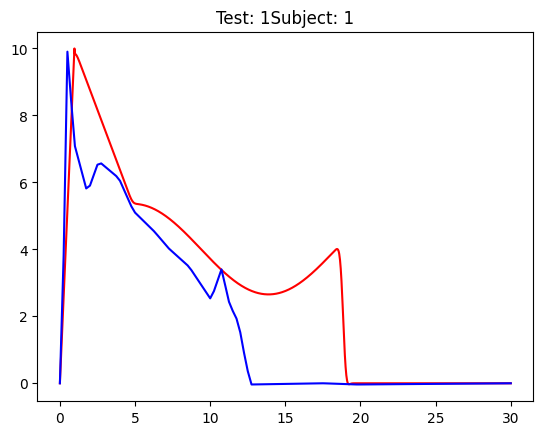

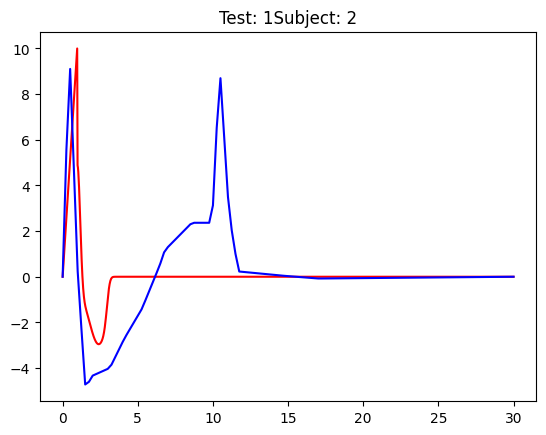

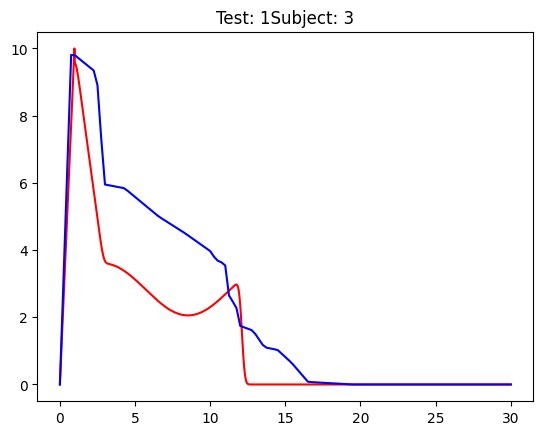

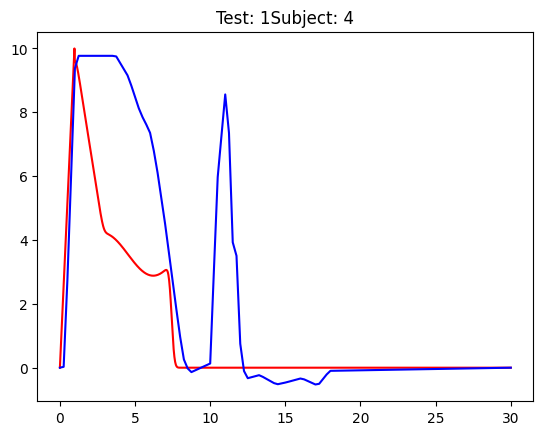

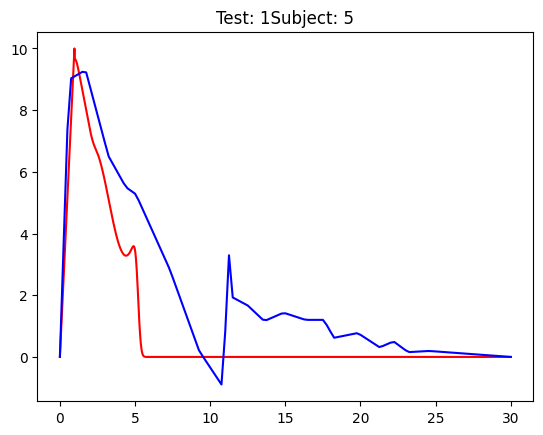

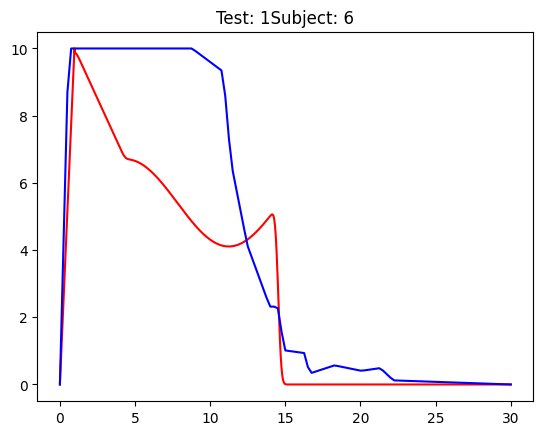

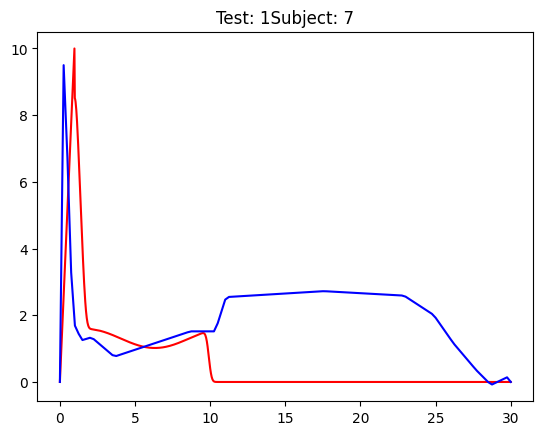

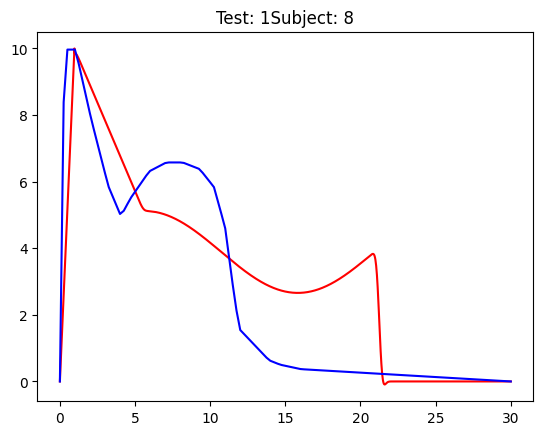

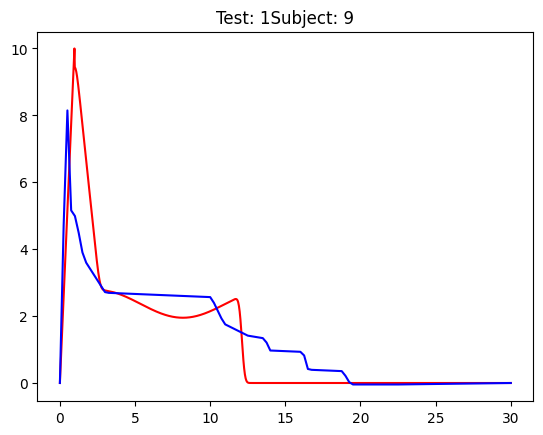

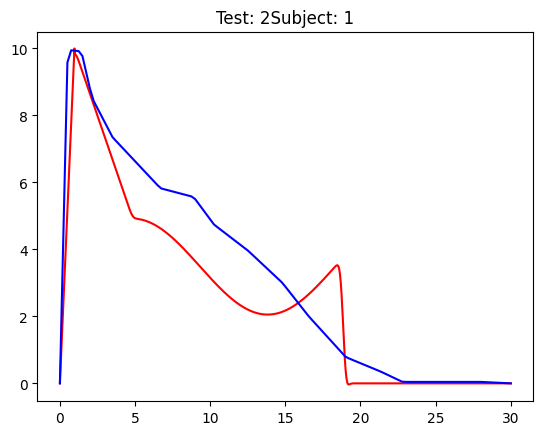

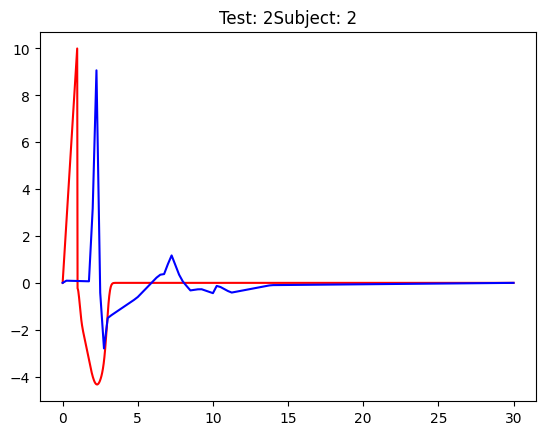

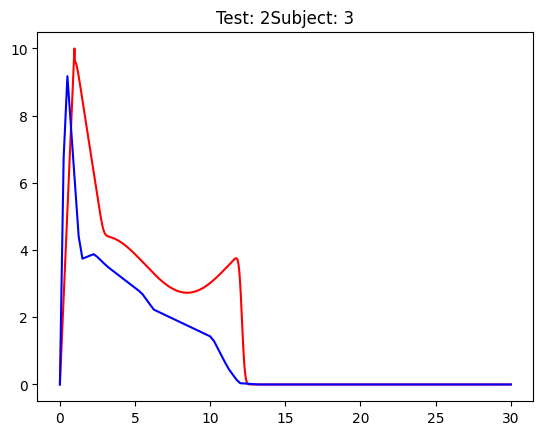

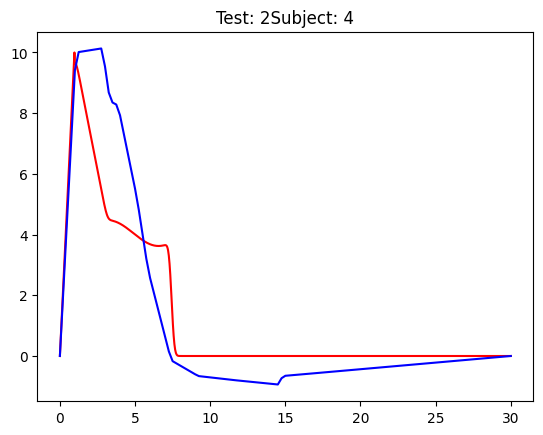

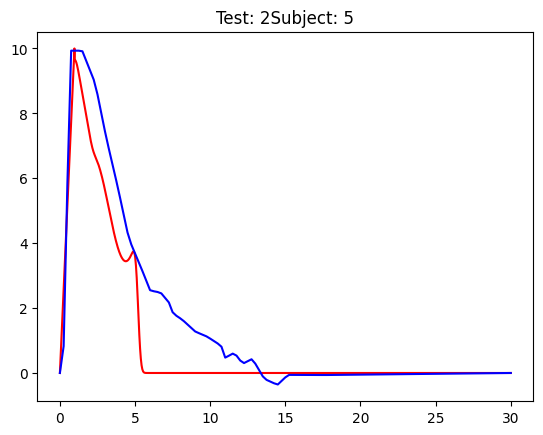

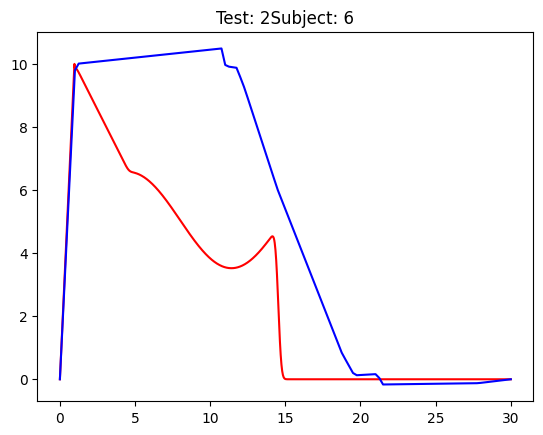

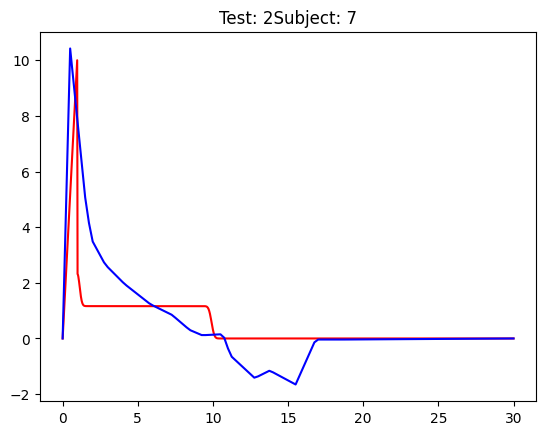

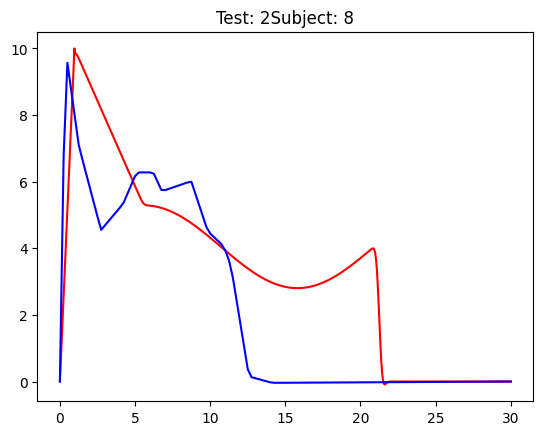

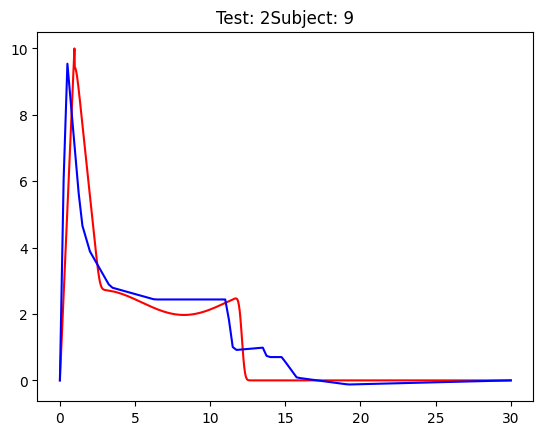

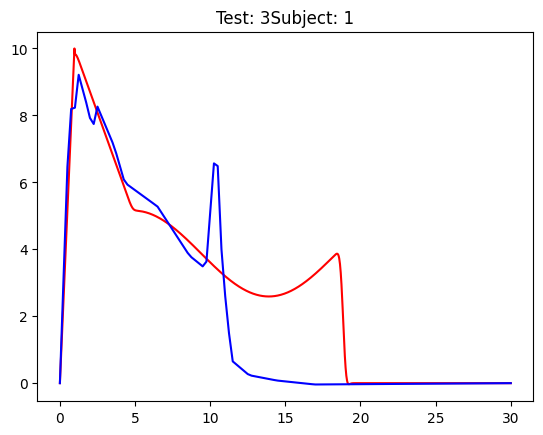

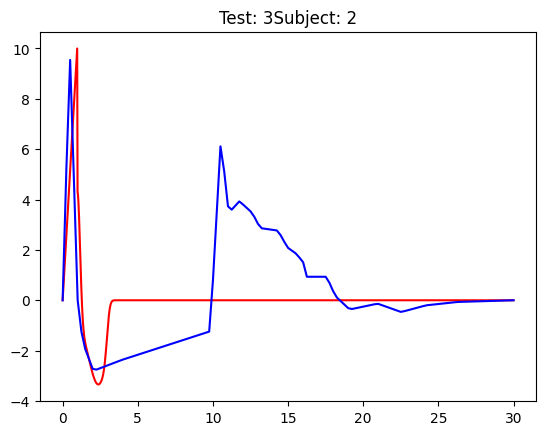

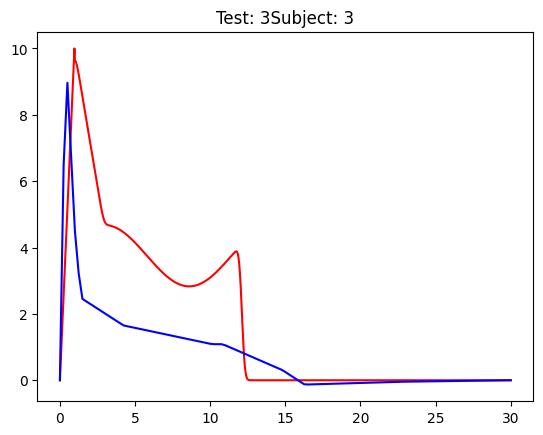

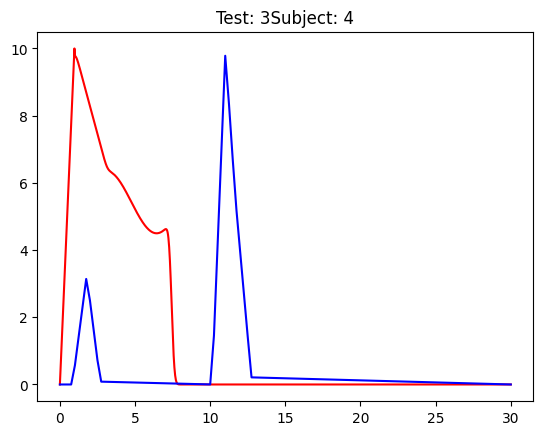

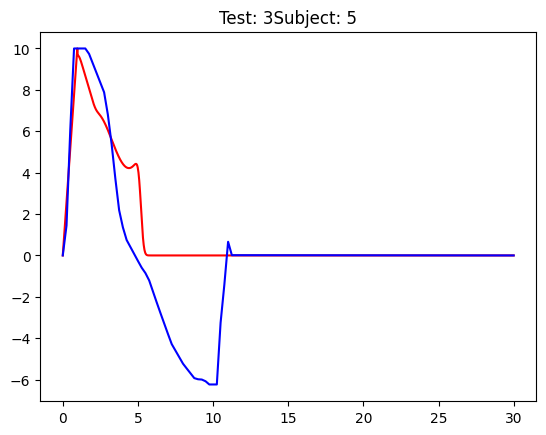

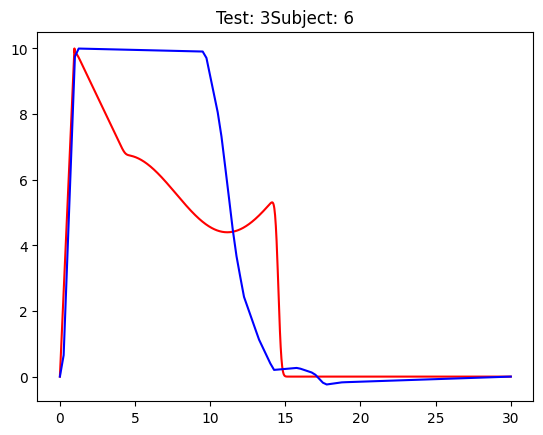

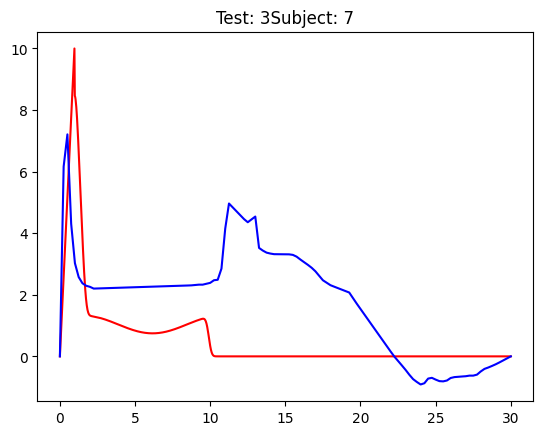

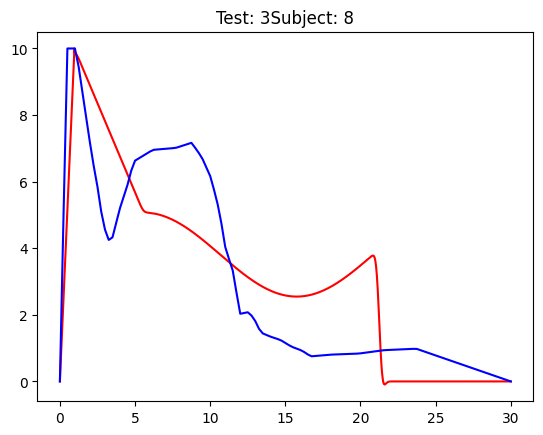

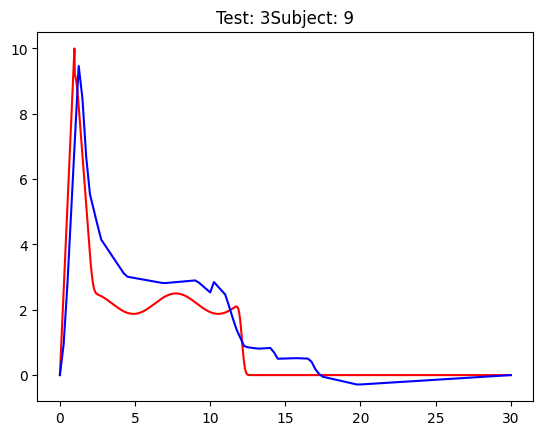

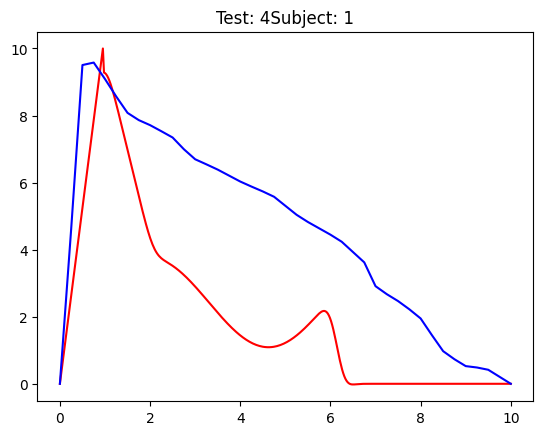

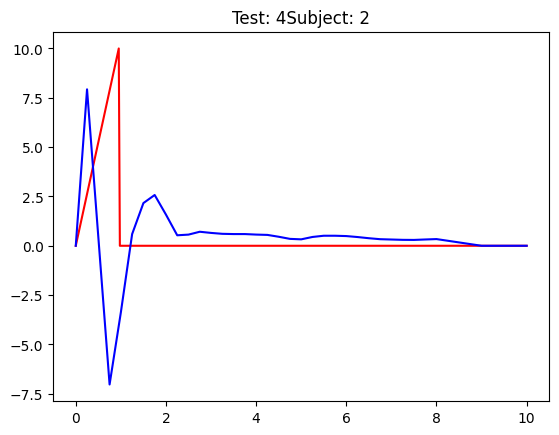

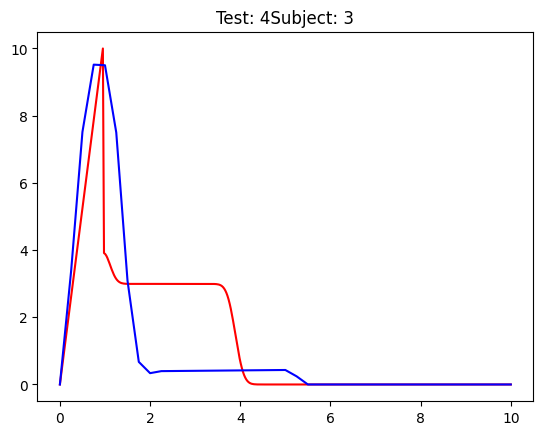

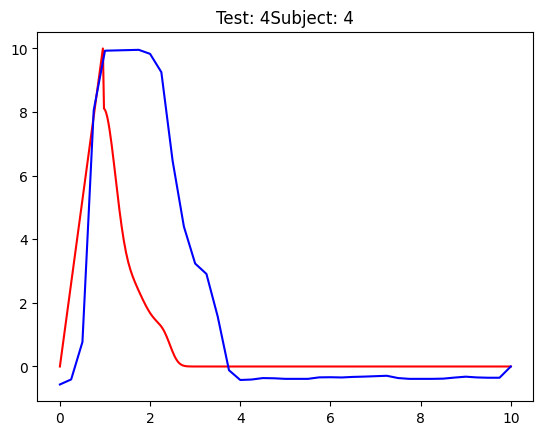

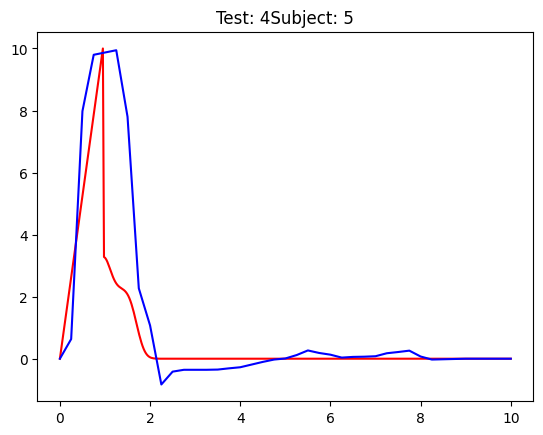

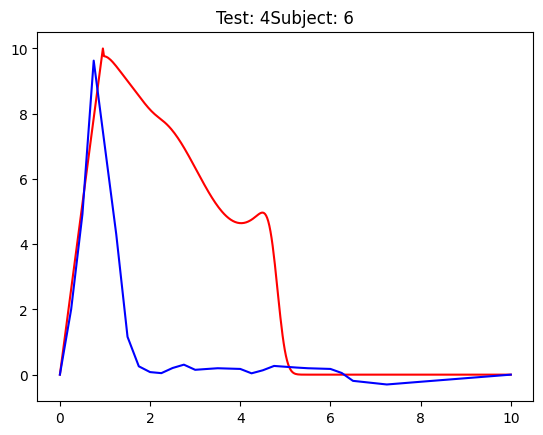

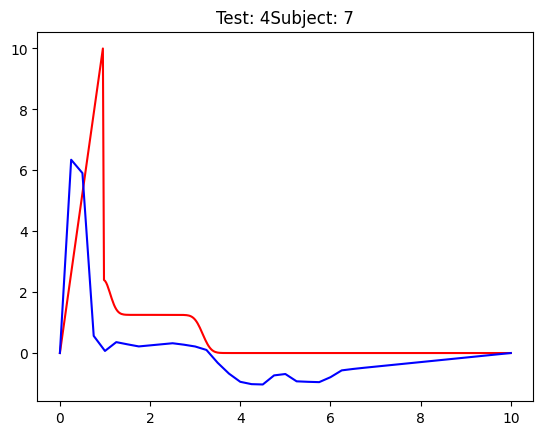

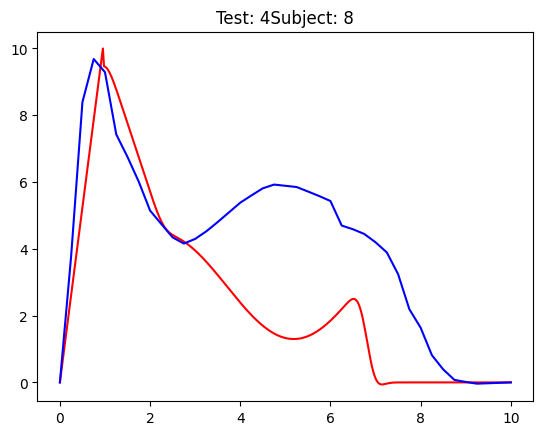

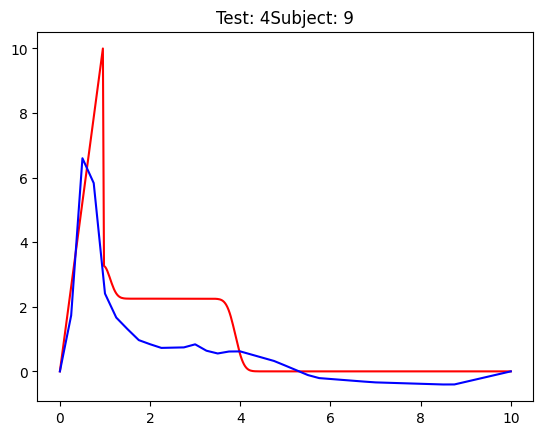

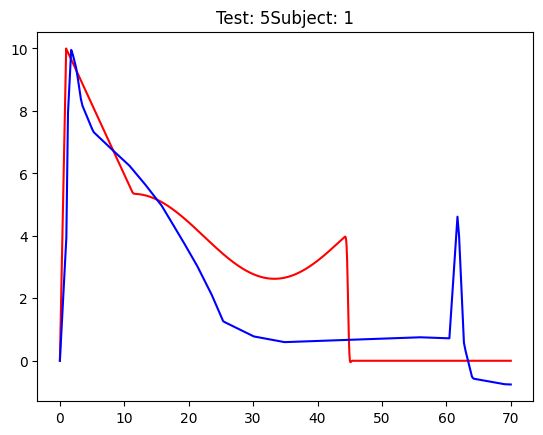

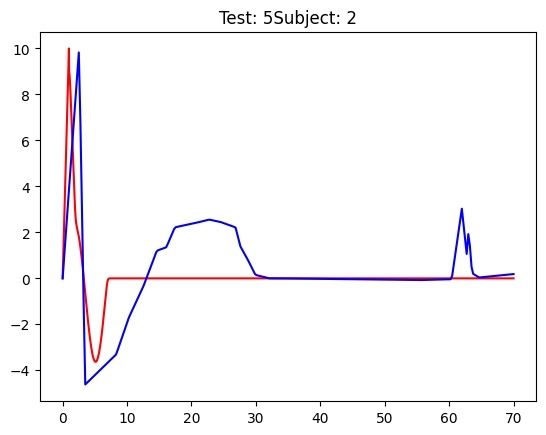

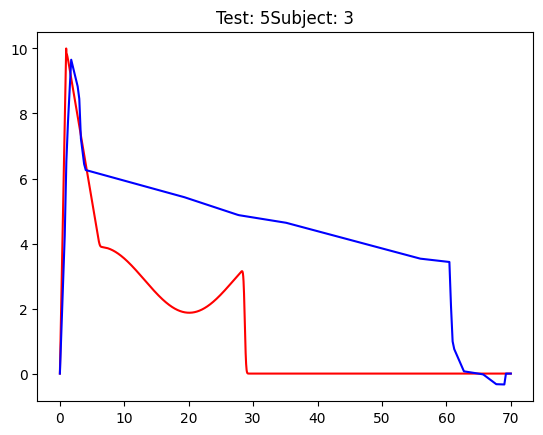

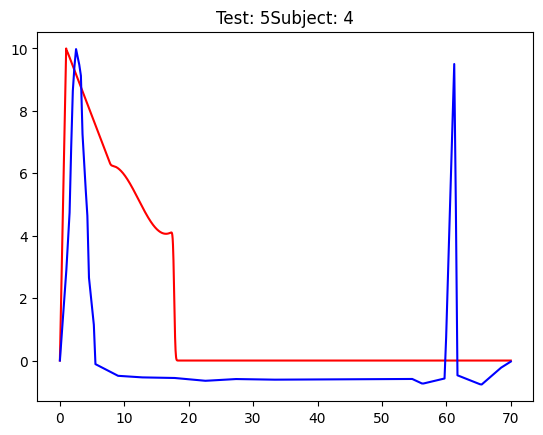

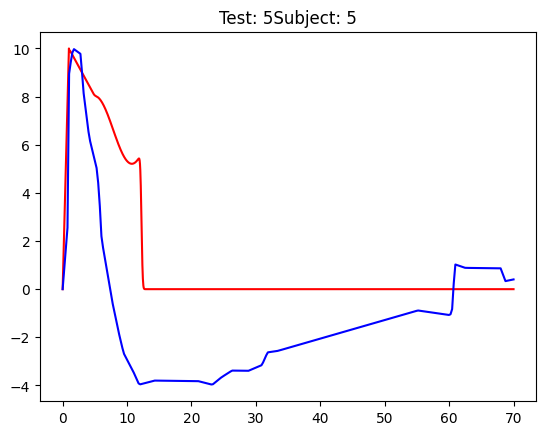

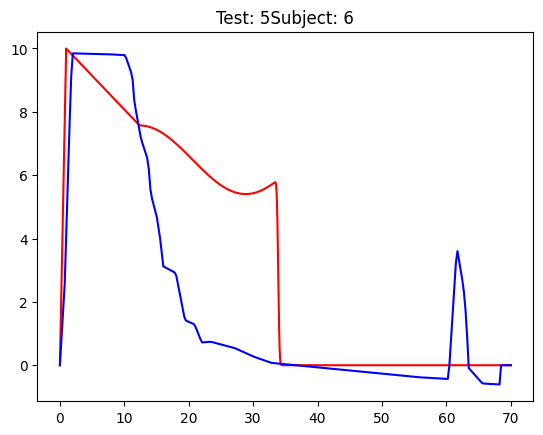

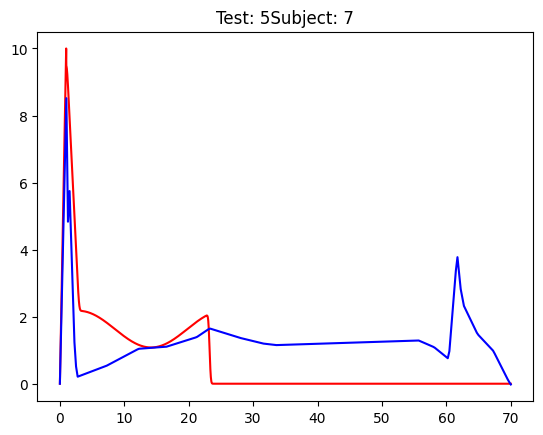

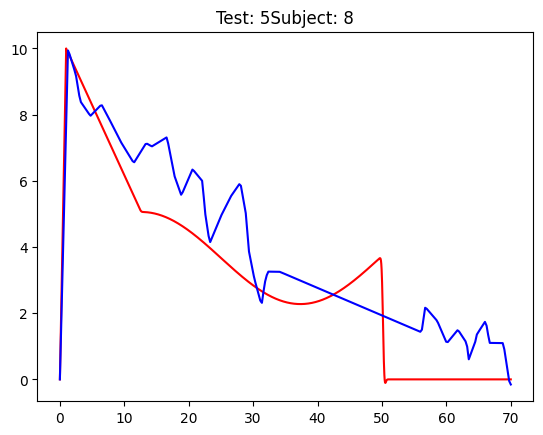

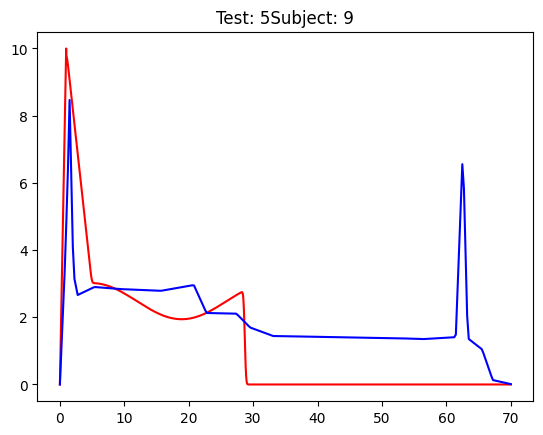

In [ ]:
plot = True
sets = [[0,9,18,27,36], [1,10,19,28,37], [2,11,20,29,38], [3,12,21,30,39],[4,13,22,31,40], [5,14,23,32,41], [6,15,24,33,42], [7,16,25,34,43], [8,17,26,35,44]]
train_mse_lst, validation_mse_lst = [], []
train_corr_lst, val_corr_lst = [],[]
for i in range(45):
  baseline = makebaseline(sets[i%9],i)
  bias= best_alpha_map[i%9 + 1][0]
  t0 = best_tau_map[i%9 + 1]
  training_mse,validation_mse, training_corr, validation_corr, baseline_model = findoptimal(sets[0],baseline,i, bais=bias, t0=t0, terms=2)
  if plot:
    plt.figure(i)
    x = x_map[i//9 + 1]
    x_interp = np.interp(np.linspace(0, len(x)-1, len(x)*10), np.arange(len(x)), x)
    result = baseline_model
    plt.plot(x_interp, result, 'r')
    plt.plot(x, data_np[i][0:len(x)], 'b')
    plt.title("Test: " + str(i // 9 + 1) + "Subject: " + str(i % 9 + 1))
  validation_mse_lst.append(validation_mse)
  train_mse_lst.append(training_mse)
  train_corr_lst.append(training_corr)
  val_corr_lst.append(validation_corr)

PRINTING RESULTS

In [ ]:
for i in range(9):
    mean, ci = group_by_subject(validation_mse_lst, i, ci=True)
    print(f"subject: {i+1}, validation mse score: {mean:.3f} ± {ci:.3f}")


print("-------------------------------------------")

for i in range(9):
    mean, ci = group_by_subject(val_corr_lst, i, ci=True)
    print(f"subject: {i+1}, validation correlation score: {mean:.3f} ± {ci:.3f}")

total_validation_mse = sum(validation_mse_lst)
print("Total validation MSE:", total_validation_mse)


subject: 1, validation mse score: 3.644 ± 2.429
subject: 2, validation mse score: 4.232 ± 1.751
subject: 3, validation mse score: 4.099 ± 2.930
subject: 4, validation mse score: 7.271 ± 2.703
subject: 5, validation mse score: 4.470 ± 3.058
subject: 6, validation mse score: 8.782 ± 3.047
subject: 7, validation mse score: 3.066 ± 1.260
subject: 8, validation mse score: 3.630 ± 1.282
subject: 9, validation mse score: 1.146 ± 0.531
-------------------------------------------
subject: 1, validation correlation score: 0.880 ± 0.031
subject: 2, validation correlation score: 0.159 ± 0.378
subject: 3, validation correlation score: 0.807 ± 0.084
subject: 4, validation correlation score: 0.596 ± 0.284
subject: 5, validation correlation score: 0.843 ± 0.080
subject: 6, validation correlation score: 0.800 ± 0.128
subject: 7, validation correlation score: 0.465 ± 0.220
subject: 8, validation correlation score: 0.827 ± 0.050
subject: 9, validation correlation score: 0.861 ± 0.064
Total validation MSE

In [ ]:
# @title
best_alpha_map

In [ ]:
averages_val_mse, stds_val_mse = group(validation_mse_lst, ci=True)
for i in range(len(averages_val_mse)):
    print(f"figure: {i+3}, validation mse score: {averages_val_mse[i]:.3f} ± {stds_val_mse[i]:.3f}")

print("----------------------------------------------")

averages_val_corr, stds_val_corr = group(val_corr_lst, ci=True)
for i in range(len(averages_val_corr)):
    print(f"figure: {i+3}, validation corr score: {averages_val_corr[i]:.3f} ± {stds_val_corr[i]:.3f}")

total_validation_mse = sum(validation_mse_lst)
print("Total validation MSE:", f"{total_validation_mse:.4f}")


figure: 3, validation mse score: 3.471 ± 1.046
figure: 4, validation mse score: 2.983 ± 1.998
figure: 5, validation mse score: 4.333 ± 1.772
figure: 6, validation mse score: 6.227 ± 2.633
figure: 7, validation mse score: 5.397 ± 2.453
----------------------------------------------
figure: 3, validation corr score: 0.752 ± 0.175
figure: 4, validation corr score: 0.760 ± 0.239
figure: 5, validation corr score: 0.652 ± 0.197
figure: 6, validation corr score: 0.603 ± 0.258
figure: 7, validation corr score: 0.698 ± 0.088
Total validation MSE: 201.6980


In [ ]:
print(np.mean(validation_mse_lst))
print(np.std(validation_mse_lst))
print("------------------")
print(np.mean(val_corr_lst))
print(np.std(val_corr_lst))

4.482178261293274
3.3702144029372025
------------------
0.6931335479162036
0.31215934558834
